# Explore UniProt keywords

url: https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=%28taxonomy_id%3A9606%29
1. Select the following columns:
Entry	Entry Name	Protein Names	Gene Names	Organism	Keywords HGNC

2. Select Reviewed only (~20,500)

In [1]:
from collections import Counter

import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it

import os.path as osp
import json

Below, I downloaded the [UniProt table for human proteins](https://www.uniprot.org/uniprotkb?query=%28Human%29). I added on Keywords and HGNC as columns:

In [2]:
MAPPING_DIR = '../data/mappings/'

In [3]:
# Release 2022_05
uniprot = pd.read_csv(
    osp.join(MAPPING_DIR, 'uniprotkb_Human_AND_reviewed_true_2023_10_05.tsv.gz'),
    sep='\t',
    compression='gzip',
    usecols=[
        'Keywords',
        'Entry',
    ]
)

In [4]:
uniprot.head(10)

,Entry,Keywords
0,A0A024B7W1,3D-structure;4Fe-4S;Activation of host autopha...
1,A0A068B6Q6,3D-structure;Acetylcholine receptor inhibiting...
2,A0A076FFM5,2Fe-2S;Chloroplast;Cytoplasm;Iron;Iron-sulfur;...
3,A0A087X1C5,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...
4,A0A0A1I6E7,Amidation;Antibiotic;Antimicrobial;Cleavage on...
5,A0A0A1I6N9,Amidation;Antibiotic;Antimicrobial;Cleavage on...
6,A0A0B4J2F0,Direct protein sequencing;Membrane;Mitochondri...
7,A0A0B4J2F2,ATP-binding;Kinase;Magnesium;Metal-binding;Nuc...
8,A0A0B4KGY6,Alternative splicing;Cytoplasm;mRNA processing...
9,A0A0B4U9L8,Calcium;Cell adhesion impairing toxin;Direct p...


Get our KG and all the protein nodes inside. We are getting the KG which includes the test set:

In [5]:
KG_DIR = '../data/kg'

In [6]:
kg = pd.read_csv(osp.join(KG_DIR, 'final_kg.tsv'), sep='\t')

Get the proteins:

In [7]:
target_sets = set(kg[kg['target'].str.startswith('ncbigene')]['target'].tolist())
source_sets = set(kg[kg['source'].str.startswith('ncbigene')]['source'].tolist())
proteins_in_kg = target_sets.union(source_sets)
len(proteins_in_kg)

9301

Next, let's get a mapping from UniProt to NCBI gene ID:

In [8]:
with open(osp.join(MAPPING_DIR, 'uniprot2ncbi.json')) as f:
    uniprot2ncbi = json.load(f)

Get the valid protein classes:

In [9]:
valid_keywords = pd.read_csv(
    osp.join(MAPPING_DIR, 'molecular_function.tsv'),
    sep='\t',
)

In [10]:
valid_keywords

,Keyword ID,Name,Category,Gene Ontologies
0,KW-0008,Acetylcholine receptor inhibiting toxin,Molecular function,GO:0030550:acetylcholine receptor inhibitor ac...
1,KW-0009,Actin-binding,Molecular function,GO:0003779:actin binding
2,KW-0010,Activator,Molecular function,NaN
3,KW-0012,Acyltransferase,Molecular function,GO:0016746:acyltransferase activity
4,KW-0021,Allosteric enzyme,Molecular function,"GO:0003824:catalytic activity, GO:0008152:meta..."
...,...,...,...,...
193,KW-1244,Viral short tail ejection system,Molecular function,GO:0099002:viral genome ejection through host ...
194,KW-1255,Viral exotoxin,Molecular function,NaN
195,KW-1265,Chloride channel impairing toxin,Molecular function,NaN
196,KW-1275,Proton-gated sodium channel impairing toxin,Molecular function,NaN


In [11]:
molecular_functions = valid_keywords.Name.unique()

Now, we'll make a dictionary mapping each of our KG proteins to their protein class (or keywords):

In [12]:
all_keywords = []

not_mapped = 0
no_keywords = 0

protein_to_keywords = {}

for prot_name, keywords in tqdm(uniprot.values):
    # Map from UniProt to NCBI
    if 'UniProt:' + str(prot_name) not in uniprot2ncbi:
        not_mapped += 1
        continue
    
    """Get keywords"""
    protein_keywords = set()
    
    for keyword in keywords.split(';'):
        
        if keyword not in molecular_functions:
            continue
        
        protein_keywords.add(keyword.strip())
        all_keywords.append(keyword.strip())
        
    if not protein_keywords:
        no_keywords += 1
        continue
        
    protein_to_keywords[uniprot2ncbi['UniProt:' + str(prot_name)]] = protein_keywords

100%|██████████| 51790/51790 [00:01<00:00, 26615.96it/s]


In [13]:
len(protein_to_keywords), no_keywords, not_mapped, len(set(all_keywords))

(11220, 8880, 31690, 130)

Which keywords are most common? 

In [14]:
valid_keywords = [
    k
    for k, c in Counter(all_keywords).items()
    if c > 50
]

In [15]:
len(valid_keywords)

61

Removing superclasses and keywords with a few proteins

In [16]:
protein_to_keywords = {
    protein: {
        keyword
        for keyword in keywords
        if keyword in valid_keywords and keyword not in [
            'Transducer',
            'Serine/threonine-protein kinase',
            'Activator',
        ]
    }
    for protein, keywords in protein_to_keywords.items()
}

Map the proteins in our KG to Uniprot keywords:

In [17]:
nodes2keywords = {key: val for key, val in protein_to_keywords.items() if key in proteins_in_kg and len(val) > 0}

Those which map to classes:

In [18]:
len(nodes2keywords)

6378

Those which don't:

In [19]:
len(proteins_in_kg) - len(nodes2keywords)

2923

In [20]:
2769 / (1268+2769)

0.6859053752786722

Get some further stats:

In [21]:
keywords_in_nodes = list()
number_of_keywords = dict()
for key, val in nodes2keywords.items():
    keywords_in_nodes.extend(list(val))
    number_of_keywords[key] = len(val)

Let's see the most popular classes:

In [22]:
most_popular = Counter(keywords_in_nodes)
most_popular.most_common()

[('Transferase', 1190),
 ('Receptor', 1188),
 ('DNA-binding', 1071),
 ('Hydrolase', 948),
 ('G-protein coupled receptor', 681),
 ('Developmental protein', 498),
 ('Kinase', 483),
 ('Oxidoreductase', 393),
 ('RNA-binding', 387),
 ('Repressor', 341),
 ('Ion channel', 234),
 ('Protease', 232),
 ('Ribonucleoprotein', 206),
 ('Chromatin regulator', 170),
 ('Cytokine', 167),
 ('Glycosyltransferase', 155),
 ('Actin-binding', 133),
 ('Lyase', 129),
 ('Ribosomal protein', 124),
 ('Calmodulin-binding', 115),
 ('Growth factor', 109),
 ('Chaperone', 107),
 ('GTPase activation', 98),
 ('Voltage-gated channel', 95),
 ('Tyrosine-protein kinase', 95),
 ('Acyltransferase', 92),
 ('Ligase', 86),
 ('Motor protein', 83),
 ('Isomerase', 81),
 ('Guanine-nucleotide releasing factor', 79),
 ('Protein phosphatase', 79),
 ('Helicase', 78),
 ('Ligand-gated ion channel', 75),
 ('Heparin-binding', 75),
 ('Translocase', 74),
 ('Hormone', 73),
 ('Methyltransferase', 72),
 ('Thiol protease', 70),
 ('Metalloprotease',

How many classes per protein?

/home/lauren/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-3.6805555555555554, 0.5, 'Number of nodes')

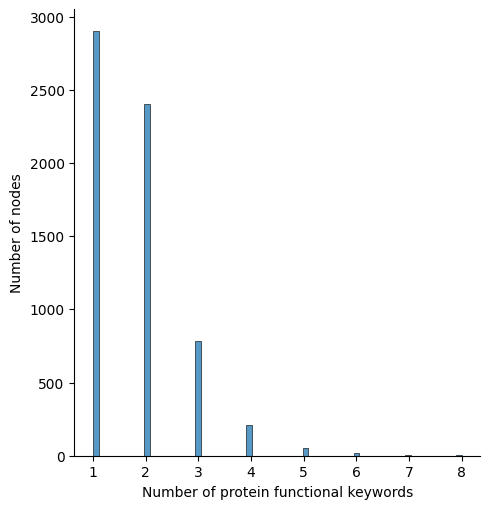

In [23]:
sns.displot(list(number_of_keywords.values()))
# add x axis label
plt.xlabel("Number of protein functional keywords")
# add y axis label
plt.ylabel("Number of nodes")

From those above, we want to reduce the number of keywords. Let's see how many keywords are amongst those with just 1 keyword:

In [24]:
# get all the protein IDs
single_keyword = {key for key, val in number_of_keywords.items() if val == 1}

In [25]:
# and then the corresponding keywords to those proteins
kws = set()
for key, val in nodes2keywords.items():
    if key in single_keyword:
        kws.update(val)

In [26]:
# now subet nodes2keywords to include only those proteins with a single keyword
nodes2keywords = {key: val.intersection(kws) for key, val in nodes2keywords.items() if len(val.intersection(kws)) > 0}

In [27]:
len(nodes2keywords)

6378

How much of the proteins in the KG does that cover?

In [28]:
len(nodes2keywords) / len(proteins_in_kg)

0.68573271691216

In [29]:
len(kws)

28

We'll cut these down a bit more to start small:

First, get all the proteins connected to drugs or BPS:

In [30]:
prots2bps = set(kg.loc[kg['edge_type'] == 'participates']['source'])

prots_frm_drugs = set(kg.loc[(kg['edge_type'] == 'upregulates') | (kg['edge_type'] == 'downregulates')]['target'])

In [31]:
critical_prots = prots2bps | prots_frm_drugs

In [32]:
# and then the corresponding keywords to those proteins
critical_kws = list()
kw_freqs = list()
for key, val in nodes2keywords.items():
        for word in val:
            if key in critical_prots:
                critical_kws.append(word)
            kw_freqs.append(word)

In [33]:
critical_counts = Counter(critical_kws)
kw_freqs_counts = Counter(kw_freqs)

Now, we see what percentage of each class comprises vital proteins:

In [34]:
percentages = dict()
for key, val in kw_freqs_counts.items():
    if key in critical_counts:
        percentages[key] = critical_counts[key] / val
    else:
        percentages[key] = 0

In [35]:
percentages = Counter(percentages).most_common()

In [36]:
percentages

[('Growth factor', 0.8256880733944955),
 ('Hormone', 0.821917808219178),
 ('Heparin-binding', 0.76),
 ('Protease inhibitor', 0.7307692307692307),
 ('Cytokine', 0.7245508982035929),
 ('Ion channel', 0.6495726495726496),
 ('Chaperone', 0.6355140186915887),
 ('Translocase', 0.6081081081081081),
 ('Developmental protein', 0.606425702811245),
 ('Isomerase', 0.5555555555555556),
 ('Antimicrobial', 0.5172413793103449),
 ('Hydrolase', 0.5073839662447257),
 ('Calmodulin-binding', 0.4956521739130435),
 ('Repressor', 0.45161290322580644),
 ('GTPase activation', 0.4489795918367347),
 ('Oxidoreductase', 0.44529262086513993),
 ('Guanine-nucleotide releasing factor', 0.43037974683544306),
 ('Transferase', 0.4226890756302521),
 ('Lyase', 0.4186046511627907),
 ('Receptor', 0.398989898989899),
 ('Chromatin regulator', 0.3764705882352941),
 ('DNA-binding', 0.3445378151260504),
 ('Actin-binding', 0.3233082706766917),
 ('RNA-binding', 0.27648578811369506),
 ('Motor protein', 0.2289156626506024),
 ('Muscle 

In [37]:
kw_freqs_counts.most_common()

[('Transferase', 1190),
 ('Receptor', 1188),
 ('DNA-binding', 1071),
 ('Hydrolase', 948),
 ('Developmental protein', 498),
 ('Oxidoreductase', 393),
 ('RNA-binding', 387),
 ('Repressor', 341),
 ('Ion channel', 234),
 ('Ribonucleoprotein', 206),
 ('Chromatin regulator', 170),
 ('Cytokine', 167),
 ('Actin-binding', 133),
 ('Lyase', 129),
 ('Calmodulin-binding', 115),
 ('Growth factor', 109),
 ('Chaperone', 107),
 ('GTPase activation', 98),
 ('Ligase', 86),
 ('Motor protein', 83),
 ('Isomerase', 81),
 ('Guanine-nucleotide releasing factor', 79),
 ('Heparin-binding', 75),
 ('Translocase', 74),
 ('Hormone', 73),
 ('Protease inhibitor', 52),
 ('Muscle protein', 48),
 ('Antimicrobial', 29)]

The code below gets us a good amount, but we'll start with a smaller number to test it out:

In [38]:
# keep_kws should be the words in percentages corresponding to those with >80% value
#keep_kws = {key for key, val in percentages if val > 0.80 or kw_freqs_counts[key] > 150}
#len(keep_kws)

In [39]:
# keep_kws should be the words in percentages corresponding to those with >80% value
keep_kws = {key for key, val in percentages if val > 0.5}
#keep_kws = {key for key, val in kw_freqs_counts.items() if val > 1000}
len(keep_kws)

12

Okay, how many do we have left?

In [40]:
# now subet nodes2keywords to include only those proteins with a single keyword
nodes2keywords = {key: val.intersection(keep_kws) for key, val in nodes2keywords.items() if len(val.intersection(keep_kws)) > 0}

In [41]:
len(nodes2keywords) / len(proteins_in_kg)

0.24104934953230836

We still have about a quarter left.

So if we narrow it down to these classes, we still include all the proteins we had before.

In [42]:
# get most_popular for only terms for kws
keyword_freqs = {key: val for key, val in most_popular.items() if key in keep_kws}
keyword_freqs

{'Hydrolase': 948,
 'Ion channel': 234,
 'Developmental protein': 498,
 'Cytokine': 167,
 'Translocase': 74,
 'Chaperone': 107,
 'Growth factor': 109,
 'Heparin-binding': 75,
 'Isomerase': 81,
 'Antimicrobial': 29,
 'Protease inhibitor': 52,
 'Hormone': 73}

Okay, let's get a dictionary mapping proteins in the KG to their class. If they don't map to anything, map them to a generic protein class ('Gene', to keep it consistent with the KG).

In [43]:
node2class = dict()
no_class_nodes = set()

for node in proteins_in_kg: # take away non-critical proteins that don't have a keyword
    if node in nodes2keywords:
        node2class[node] = list(nodes2keywords[node])
    elif node in critical_prots:  
        #node2class[node] = ['Gene']
        no_class_nodes.add(node)

In [44]:
# get rid of the ones that are neither critical nor have any keywords
nodes2remove = set(proteins_in_kg) - set(node2class.keys())
len(nodes2remove)

7059

In [45]:
# write dictionary to json file in MAPPING_DIR
with open(osp.join(MAPPING_DIR, 'node2class.json'), 'w') as f:
    json.dump(node2class, f, indent=4)

## Alter the KG:

Now, we want to alter the KG so that we replace rows with the interactions from those limited classes.

In [46]:
kg.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Gene,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates
2,pubchem.compound:10607,Compound,ncbigene:54658,Gene,downregulates
3,pubchem.compound:10607,Compound,ncbigene:7153,Gene,downregulates
4,pubchem.compound:10607,Compound,ncbigene:7277,Gene,downregulates


Change the protein classes:

In [47]:
new_rows = []

Now we add to our new KG:

In [48]:
for i, row in tqdm(kg.iterrows()):
    # first, check whether the nodes are within our node classes:
    if row['source'] in nodes2remove or row['target'] in nodes2remove:
        continue
    # if both match:
    elif row['source'] in node2class and row['target'] in node2class:
        for combo in list(it.product(node2class[row['source']], node2class[row['target']])):
            s_kw, t_kw = combo
            kg.loc[i, 'source_node_type'] = s_kw
            kg.loc[i, 'target_node_type'] = t_kw
            new_rows.append(list(row))
    # if just the source is in our dict
    elif row['source'] in node2class:
        for kw in node2class[row['source']]:
            kg.loc[i, 'source_node_type'] = kw
            new_rows.append(list(row))
    # if just the target is in our dict
    elif row['target'] in node2class:
        for kw in node2class[row['target']]:
            kg.loc[i, 'target_node_type'] = kw
            new_rows.append(list(row))
    else:
        new_rows.append(list(row))

96569it [00:06, 14362.04it/s]


In [49]:
kg_subclass = pd.DataFrame(new_rows, columns=kg.columns)

In [50]:
kg_subclass.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Cytokine,upregulates
1,pubchem.compound:10607,Compound,ncbigene:7153,Isomerase,downregulates
2,pubchem.compound:10607,Compound,ncbigene:7277,Hydrolase,downregulates
3,pubchem.compound:10635,Compound,ncbigene:10257,Translocase,upregulates
4,pubchem.compound:10635,Compound,ncbigene:354,Hydrolase,upregulates


In [51]:
kg_subclass['source_node_type'].value_counts()

source_node_type
Compound                 3358
Developmental protein    3331
Hydrolase                1858
Growth factor            1331
Cytokine                 1036
Heparin-binding           579
Hormone                   494
Ion channel               427
Protease inhibitor        290
Chaperone                 220
Translocase               126
Isomerase                 103
Antimicrobial              44
Name: count, dtype: int64

In [52]:
kg_subclass['edge_type'].value_counts()

edge_type
interacts        8011
participates     1828
induces          1622
downregulates     985
upregulates       751
Name: count, dtype: int64

In [53]:
kg_subclass.to_csv(osp.join(KG_DIR, 'final_kg_subclassed.tsv'), sep='\t', index=False)